### Multi class Pipeline

In [21]:
#Adhoc
import sys
import random
import os
import time

#Pre-processing
import pandas as pd
import numpy as np
from datetime import datetime

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
#Classification libs

from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,cross_val_score,GridSearchCV,cross_validate
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score,precision_recall_curve,precision_score,recall_score,auc,precision_recall_curve
from sklearn.pipeline import Pipeline

#Models

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm

In [23]:
#Outcome transform
from sklearn import datasets
df = pd.read_csv('Iris.csv')
df['Species'] = LabelEncoder().fit_transform(df['Species'])

In [24]:
#Multiclass classification
df['Species'].value_counts()

0    50
1    50
2    50
Name: Species, dtype: int64

In [25]:
pipeline = Pipeline([
    ('normalizer', StandardScaler()), #Step1 - normalize data
    ('clf', LogisticRegression()) #step2 - classifier
])
pipeline.steps

[('normalizer', StandardScaler()), ('clf', LogisticRegression())]

In [26]:
clfs = []
clfs.append(LogisticRegression(penalty='none'))
clfs.append(SVC(C=1,kernel='poly',degree=5,probability=False))#Can set probab as 'bool'
clfs.append(KNeighborsClassifier(n_neighbors=3 , p=16))
clfs.append(DecisionTreeClassifier(criterion='entropy',max_depth=10,min_samples_split=60,min_samples_leaf=30,max_features='log2',ccp_alpha=0.0001))
clfs.append(RandomForestClassifier(n_estimators=200,n_jobs=3,max_samples=0.75))
clfs.append(GradientBoostingClassifier(n_estimators=200,learning_rate=0.01,subsample=0.75,n_iter_no_change=20,validation_fraction=0.20))
#clfs.append(LinearDiscriminantAnalysis(n_components=5))
#clfs.append(GaussianNB())



In [36]:
df.drop('Id',inplace=True,axis=1)
df.iloc[:,:-1]

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [44]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1].values,
                                                   df['Species'],
                                                   test_size = 0.5,
                                                   random_state = 10,stratify=df['Species'])

In [45]:
for classifier in clfs:
    pipeline.set_params(clf = classifier)
    scores = cross_val_score(pipeline, X_train, y_train)
    scores_2 = cross_validate(pipeline, X_train, y_train)
    print('---------------------------------')
    print(str(classifier))
    print('-----------------------------------')
    print(scores)
    for key, values in scores_2.items():
        print(key,' mean ', values.mean())
        print(key,' std ', values.std())

---------------------------------
LogisticRegression(penalty='none')
-----------------------------------
[1.         0.86666667 0.93333333 0.86666667 0.93333333]
fit_time  mean  0.0048811912536621095
fit_time  std  0.0005577429812770525
score_time  mean  0.00026302337646484376
score_time  std  2.3482668771499208e-05
test_score  mean  0.9199999999999999
test_score  std  0.04988876515698588
---------------------------------
SVC(C=1, degree=5, kernel='poly')
-----------------------------------
[0.93333333 0.73333333 0.8        0.66666667 0.93333333]
fit_time  mean  0.0008164405822753906
fit_time  std  5.103930940565411e-05
score_time  mean  0.0002560138702392578
score_time  std  8.690218211398095e-06
test_score  mean  0.8133333333333332
test_score  std  0.10666666666666669
---------------------------------
KNeighborsClassifier(n_neighbors=3, p=16)
-----------------------------------
[0.93333333 1.         0.93333333 0.8        0.93333333]
fit_time  mean  0.000678396224975586
fit_time  std

In [46]:
pipeline.set_params(clf= SVC())
cv_grid = GridSearchCV(pipeline, param_grid = {
    'clf__kernel' : ['linear', 'rbf'],
    'clf__C' : np.linspace(0.1,1.2,12)
})

cv_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('normalizer', StandardScaler()),
                                       ('clf', SVC())]),
             param_grid={'clf__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2]),
                         'clf__kernel': ['linear', 'rbf']})

In [47]:
cv_grid.best_params_ , cv_grid.best_estimator_, cv_grid.best_score_


({'clf__C': 0.2, 'clf__kernel': 'linear'},
 Pipeline(steps=[('normalizer', StandardScaler()),
                 ('clf', SVC(C=0.2, kernel='linear'))]),
 0.9600000000000002)

In [48]:
confusion_matrix(y_true=y_test,y_pred=cv_grid.best_estimator_.predict(X_test))

array([[25,  0,  0],
       [ 0, 24,  1],
       [ 0,  1, 24]])

In [61]:
f1_score(y_test,cv_grid.best_estimator_.predict(X_test),average='weighted')

0.9733333333333334

In [63]:
print(classification_report(y_true=y_test,y_pred=cv_grid.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       0.96      0.96      0.96        25
           2       0.96      0.96      0.96        25

    accuracy                           0.97        75
   macro avg       0.97      0.97      0.97        75
weighted avg       0.97      0.97      0.97        75



### Time Series Forecasting

In [68]:
# The data contains a particular month and number of passengers travelling in that month. In order to read the data as a time series, we have to pass special arguments to the read_csv command:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)


<ipython-input-68-21c7f261acbc>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')


In [77]:
ts = data['#Passengers']

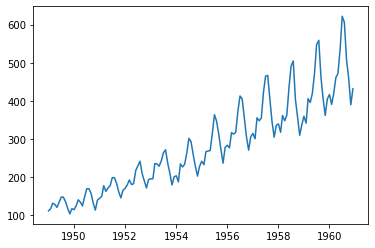

In [78]:
#While slicing right hand limit is included
plt.plot(ts)

In [82]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(ts, autolag='AIC')
dftest

(0.8153688792060442,
 0.9918802434376409,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [83]:
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

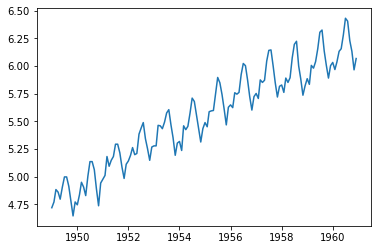

In [85]:
#Reduce trend -- take log
ts_log = np.log(ts)
plt.plot(ts_log)

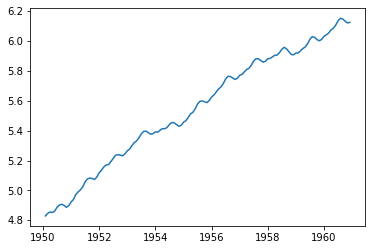

In [90]:
#Reduce seasonality
moving_avg = ts_log.rolling(14).mean()
#plt.plot(ts_log)
plt.plot(moving_avg)

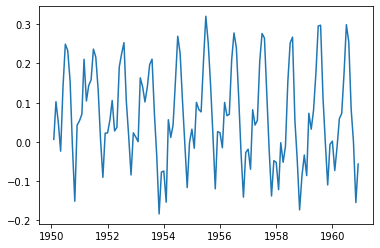

In [93]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

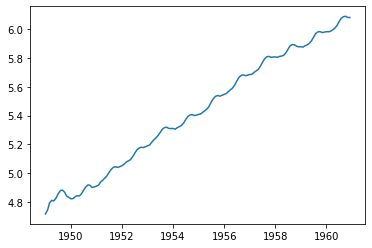

In [94]:
#Reduce seasonality
moving_avg2 = ts_log.ewm(14).mean()
#plt.plot(ts_log)
plt.plot(moving_avg2)

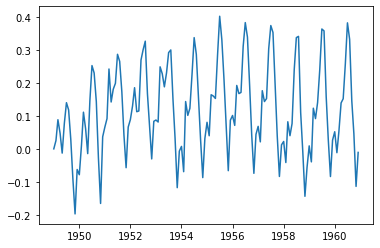

In [95]:
ts_log_moving_avg_diff = ts_log - moving_avg2
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

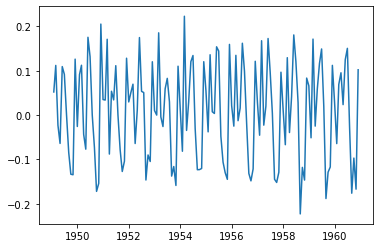

In [96]:
#Remove trend seasonality - Differencing 1
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

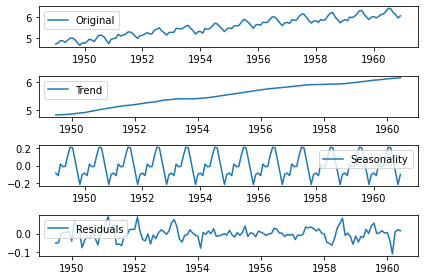

In [97]:
#Remove trend seasonality - Decompose
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [98]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
adfuller(ts_log_decompose)

(-6.3323867976448724,
 2.8850589033232728e-08,
 9,
 122,
 {'1%': -3.4851223522012855,
  '5%': -2.88553750045158,
  '10%': -2.5795685622144586},
 -517.2642969403794)

In [99]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_decompose, nlags=20)
lag_pacf = pacf(ts_log_decompose, nlags=20, method='ols')

/Users/abhinavsharma/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Text(0.5, 1.0, 'Autocorrelation Function')

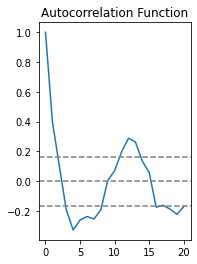

In [100]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

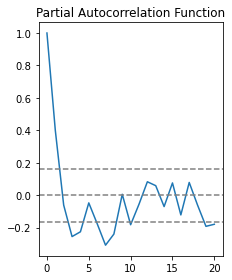

In [101]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

/Users/abhinavsharma/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/abhinavsharma/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information w

Text(0.5, 1.0, 'RSS: nan')

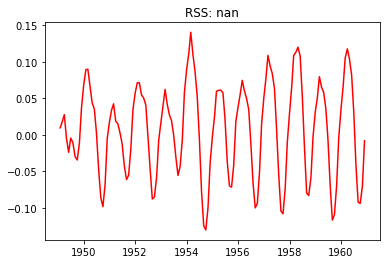

In [113]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
#plt.plot(ts_log_diff)
#plt.plot(ts_log_decompose)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

Text(0.5, 1.0, 'RMSE: 90.1047')

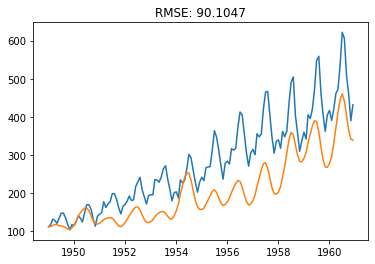

In [118]:
#Original scale
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.values[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [142]:
from datetime import timedelta
from dateutil.relativedelta import relativedelta

datetime.fromtimestamp(int(max(ts.index).timestamp())) + relativedelta(months=1)

datetime.datetime(1960, 12, 30, 18, 0)

In [143]:
from pandas import datetime
start_index = datetime.fromtimestamp(int(max(ts.index).timestamp())) + relativedelta(months=1)
end_index = datetime.fromtimestamp(int(max(ts.index).timestamp())) + relativedelta(months=24)
forecast = results_ARIMA.predict(start=start_index, end=end_index)

<ipython-input-143-99be0e06b6f8>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [144]:
forecast

1961-01-01    0.027108
1961-02-01    0.057280
1961-03-01    0.071616
1961-04-01    0.067981
1961-05-01    0.049236
1961-06-01    0.021946
1961-07-01   -0.005747
1961-08-01   -0.026454
1961-09-01   -0.035418
1961-10-01   -0.031498
1961-11-01   -0.017094
1961-12-01    0.002868
1962-01-01    0.022507
1962-02-01    0.036645
1962-03-01    0.042112
1962-04-01    0.038372
1962-05-01    0.027387
1962-06-01    0.012837
1962-07-01   -0.001044
1962-08-01   -0.010642
1962-09-01   -0.013863
1962-10-01   -0.010525
1962-11-01   -0.002205
1962-12-01    0.008364
Freq: MS, dtype: float64